Notebook to do a direct comparison between the PSF second moments published in the ConsDB vs the DRP to make sure they are not very divergent

In [1]:
from lsst.summit.utils import ConsDbClient

In [2]:
import numpy as np
from astropy.table import Table, join
from astropy.time import Time

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib widget

from lsst.meas.algorithms.installGaussianPsf import FwhmPerSigma

from tqdm.notebook import tqdm

In [3]:
def getAirmassSeeingCorrection(airmass: float) -> float:
    """Get the correction factor for seeing due to airmass.

    Parameters
    ----------
    airmass : `float`
        The airmass, greater than or equal to 1.

    Returns
    -------
    correctionFactor : `float`
        The correction factor to apply to the seeing.

    Raises
    ------
        ValueError raised for unphysical airmasses.
    """
    if airmass < 1:
        raise ValueError(f"Invalid airmass: {airmass}")
    return airmass ** (-0.6)

def getBandpassSeeingCorrection(filterName: str) -> float:
    """Get the correction factor for seeing due to a filter.

    Parameters
    ----------
    filterName : `str`
        The name of the filter, e.g. 'SDSSg_65mm'.

    Returns
    -------
    correctionFactor : `float`
        The correction factor to apply to the seeing.

    Raises
    ------
        ValueError raised for unknown filters.
    """
    match filterName:
        case "SDSSg_65mm":  # LATISS
            return (474.41 / 500.0) ** 0.2
        case "SDSSr_65mm":  # LATISS
            return (628.47 / 500.0) ** 0.2
        case "SDSSi_65mm":  # LATISS
            return (769.51 / 500.0) ** 0.2
        case "SDSSz_65mm":  # LATISS
            return (871.45 / 500.0) ** 0.2
        case "SDSSy_65mm":  # LATISS
            return (986.8 / 500.0) ** 0.2
        case "u_02":  # ComCam
            return (370.697 / 500.0) ** 0.2
        case "g_01":  # ComCam
            return (476.359 / 500.0) ** 0.2
        case "r_03":  # ComCam
            return (619.383 / 500.0) ** 0.2
        case "i_06":  # ComCam
            return (754.502 / 500.0) ** 0.2
        case "z_03":  # ComCam
            return (866.976 / 500.0) ** 0.2
        case "y_04":  # ComCam
            return (972.713 / 500.0) ** 0.2
        case _:
            raise ValueError(f"Unknown filter name: {filterName}")

In [4]:
os.environ["no_proxy"] += ",.consdb"

In [5]:
url="http://consdb-pq.consdb:8080/consdb"

In [6]:
consdb=ConsDbClient(url)

In [7]:
# Query both consDB tables
exposure = consdb.query("SELECT * FROM cdb_lsstcomcam.exposure WHERE science_program = 'BLOCK-320'")
visits = consdb.query("SELECT * FROM cdb_lsstcomcam.visit1 WHERE science_program = 'BLOCK-320'")
visits_ql = consdb.query("SELECT * FROM cdb_lsstcomcam.visit1_quicklook")

# Join using astropy's join function on 'visit_id'
exposure_join = exposure.rename_column("exposure_id", "visit_id")
merged_exposure = join(exposure, visits, keys="visit_id", join_type="inner")  
merged_visits = join(visits, visits_ql, keys="visit_id", join_type="inner")  

# Display or use the merged table
print(merged_visits)

   visit_id      exposure_name     ... psf_ap_corr_sigma_scaled_delta_median
------------- -------------------- ... -------------------------------------
2024111400038 CC_O_20241114_000038 ...                                  None
2024111400039 CC_O_20241114_000039 ...                                  None
2024111500224 CC_O_20241115_000224 ...                                  None
2024111500225 CC_O_20241115_000225 ...                                  None
2024111500226 CC_O_20241115_000226 ...                                  None
2024111500227 CC_O_20241115_000227 ...                                  None
2024111500238 CC_O_20241115_000238 ...                                  None
2024111500239 CC_O_20241115_000239 ...                                  None
2024111500240 CC_O_20241115_000240 ...                                  None
2024111500241 CC_O_20241115_000241 ...                                  None
          ...                  ... ...                                   ...

In [8]:
# Convert PSF sigma to FWHM
sig2fwhm = 2 * np.sqrt(2 * np.log(2))
pixel_scale = 0.2  # arcsec / pixel
merged_visits["psf_fwhm"] = merged_visits["psf_sigma_median"] * sig2fwhm * pixel_scale

# Add the FWHM at zenith at 500nm
merged_visits["fwhm_zenith_500nm"] = [
    fwhm * getBandpassSeeingCorrection(filt) * getAirmassSeeingCorrection(airmass)
    for fwhm, filt, airmass in zip(merged_visits["psf_fwhm"], merged_visits["physical_filter"], merged_visits["airmass"])
]

/tmp/ipykernel_3778/1793915885.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


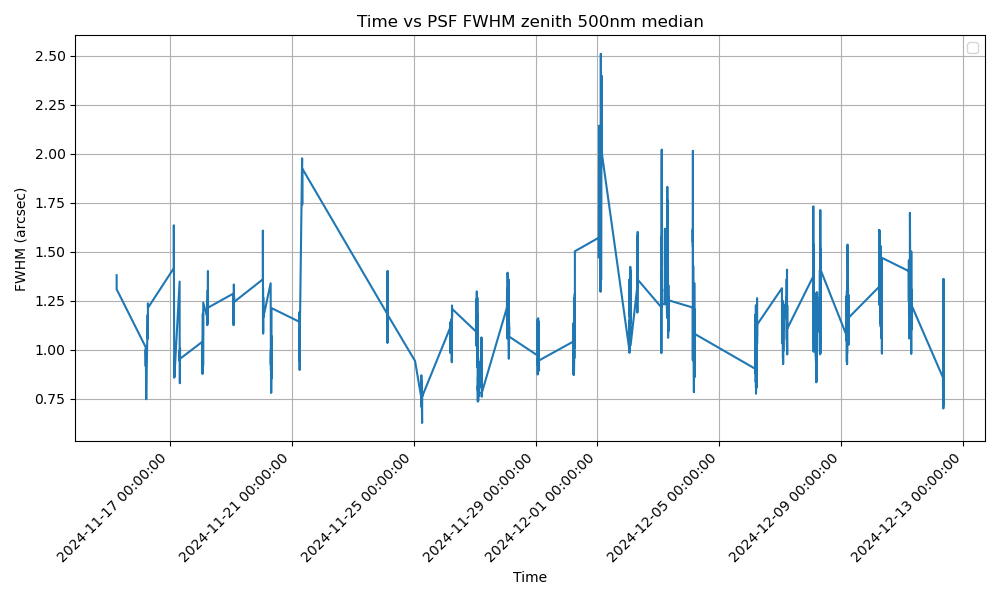

In [9]:
time = Time(merged_visits['exp_midpt'])

# Plot the time vs the specified column
plt.figure(figsize=(10, 6))
plt.plot(time.plot_date, merged_visits['psf_fwhm'])

# Set x-axis to show dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# Rotate and format x-axis labels for readability
plt.xticks(rotation=45, ha='right')

plt.xlabel('Time')
plt.ylabel('FWHM (arcsec)')
plt.title(f'Time vs PSF FWHM zenith 500nm median')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [10]:
# Load the CSV file into an Astropy Table
file_path = "ringss4rubin.csv"
ringss_data = Table.read(file_path, format="csv")

# Display table info to check structure
ringss_data.info()

<Table length=78041>
 name   dtype 
------ -------
  time   str19
  star   int64
   zen float64
  flux   int64
  see2 float64
   see float64
  fsee float64
  wind float64
  tau0 float64
theta0 float64
totvar float64
  erms float64
    J0 float64
  J025 float64
   J05 float64
    J1 float64
    J2 float64
    J4 float64
    J8 float64
   J16 float64


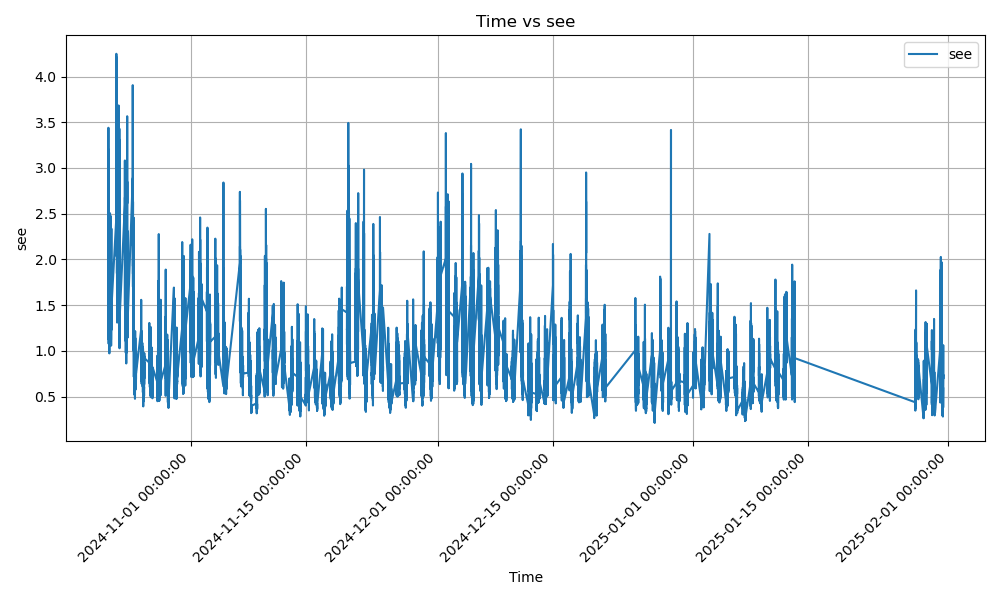

In [11]:
column_name='see'

# Convert time column to Astropy Time object
time_column = ringss_data.columns[0]
time = Time(time_column, format='iso')

# Get the data from the specified column
data = ringss_data[column_name]

# Plot the time vs the specified column
plt.figure(figsize=(10, 6))
plt.plot(time.plot_date, data, label=column_name)

# Set x-axis to show dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# Rotate and format x-axis labels for readability
plt.xticks(rotation=45, ha='right')

plt.xlabel('Time')
plt.ylabel(column_name)
plt.title(f'Time vs {column_name}')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [12]:
# Ensure time columns are Astropy Time objects
ringss_data["time"] = Time(ringss_data["time"])
merged_visits["exp_midpt"] = Time(merged_visits["exp_midpt"])

# Find the nearest neighbor index in 'table' for each entry in 'ringss_data'
idx = np.searchsorted(merged_visits["exp_midpt"].jd, ringss_data["time"].jd)

# Prevent out-of-bounds indices
idx = np.clip(idx, 0, len(merged_visits) - 1)

# Compute time differences (keeping TimeDelta)
time_diffs = merged_visits["exp_midpt"][idx] - ringss_data["time"]

# Extract seconds properly **before using NumPy operations**
time_diffs_sec = np.abs(time_diffs.sec)  # Now it's a NumPy array of seconds

# Define the max time difference threshold
max_diff = 30  # in seconds
mask = time_diffs_sec < max_diff  # Now this will work correctly

# Merge tables using the matched indices
merged_table = ringss_data[mask].copy()  # Copy only matched rows
for col in merged_visits.colnames:
    merged_table[col] = merged_visits[col][idx][mask]  # Copy matched columns

# Print merged table
print(merged_table)

          time          star  zen  ...      psf_fwhm      fwhm_zenith_500nm 
----------------------- ---- ----- ... ------------------ ------------------
2024-11-15 06:18:10.000 2294 19.97 ... 1.3804168421505336 1.1407039855454968
2024-11-15 06:19:58.000 2294 19.64 ... 1.3086806581396089 1.1222768087855142
2024-11-16 05:08:41.000 2294  33.0 ... 1.0136697040652265 0.9359121206645767
2024-11-16 05:11:35.000 2294 32.39 ... 0.9159013947066961 0.9020473900584309
2024-11-16 05:32:44.000 2294 28.01 ... 0.7716105137340328  0.793289477014486
2024-11-16 05:33:56.000 2294 27.77 ...  0.777277560770332 0.8306619563835063
2024-11-16 05:35:50.000 2294 27.38 ... 0.7480678939262441 0.8212663598800337
2024-11-16 05:37:02.000 2294 27.14 ... 0.7746633609947131 0.8493383838179049
2024-11-16 05:38:51.000 2294 26.77 ... 0.7845357646444814 0.8357091985400594
2024-11-16 06:43:40.000 2294 15.24 ... 1.1789017495957357 1.1406573570874603
                    ...  ...   ... ...                ...                ...

In [13]:
sqr_diff = merged_table["fwhm_zenith_500nm"]**2.0 - merged_table["see"]**2.0

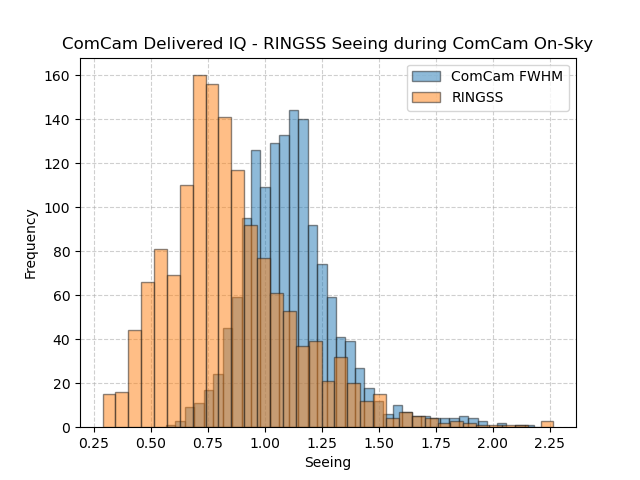

In [14]:
# Plot histogram using Freedman-Diaconis rule
plt.figure()
plt.xlabel('Seeing')
plt.ylabel("Frequency")
plt.title(f"ComCam Delivered IQ - RINGSS Seeing during ComCam On-Sky")
plt.grid(True, linestyle="--", alpha=0.6, zorder=0)
plt.hist(merged_table["fwhm_zenith_500nm"], bins='fd', edgecolor='0.1', zorder=2,alpha=0.5, label='ComCam FWHM')
plt.hist(merged_table["see"], bins="fd", edgecolor='0.1', zorder=3,alpha=0.5, label='RINGSS')
plt.legend()
plt.show()

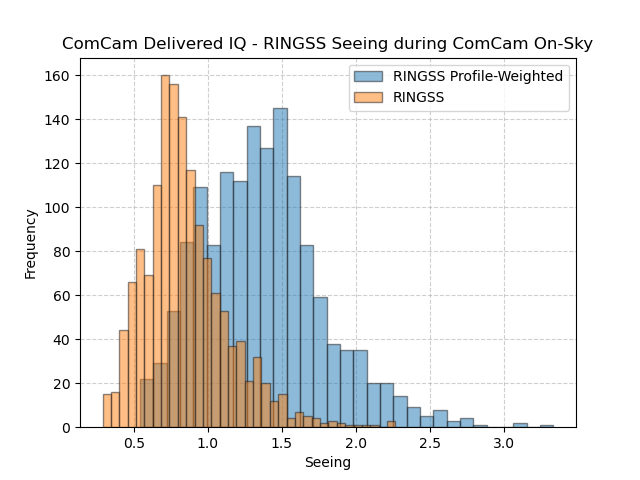

In [15]:
# Plot histogram using Freedman-Diaconis rule
plt.figure()
plt.xlabel('Seeing')
plt.ylabel("Frequency")
plt.title(f"ComCam Delivered IQ - RINGSS Seeing during ComCam On-Sky")
plt.grid(True, linestyle="--", alpha=0.6, zorder=0)
plt.hist(merged_table["see2"], bins='fd', edgecolor='0.1', zorder=2,alpha=0.5, label='RINGSS Profile-Weighted')
plt.hist(merged_table["see"], bins="fd", edgecolor='0.1', zorder=3,alpha=0.5, label='RINGSS')
plt.legend()
plt.show()

/tmp/ipykernel_3778/3115635842.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


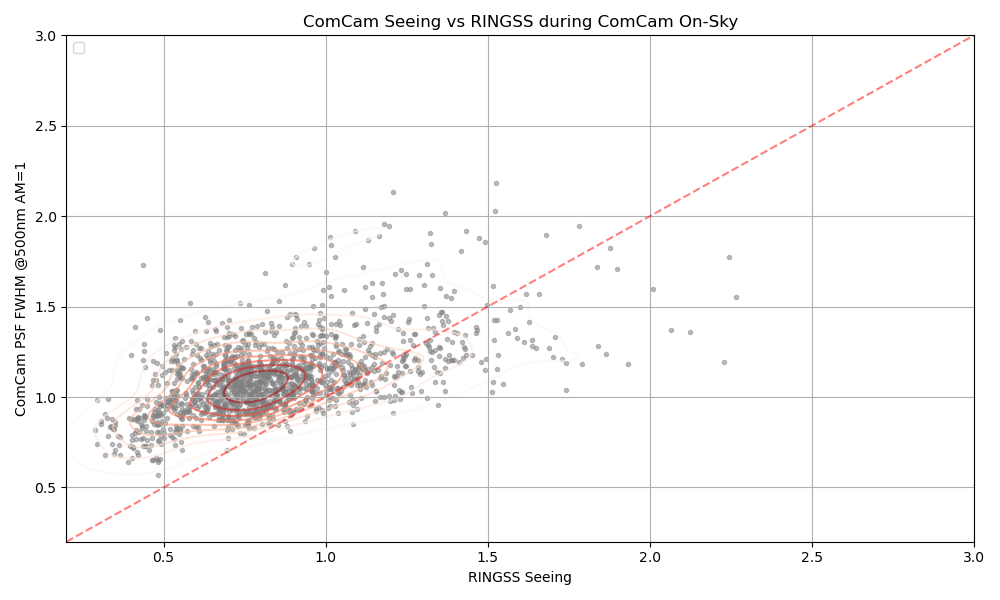

In [16]:
# Plot the time vs the specified column
plt.figure(figsize=(10, 6))
plt.plot(merged_table["see"], merged_table["fwhm_zenith_500nm"],'.', color='0.5',zorder=0, alpha=0.5)
sns.kdeplot(
    x=merged_table["see"], 
    y=merged_table["fwhm_zenith_500nm"], 
    levels=10,  # Number of contour levels
    cmap="Reds",  # Color map for contours
    alpha=0.6,
    zorder=1,
)

plt.plot(np.arange(0.2,5,0.1), np.arange(0.2,5,0.1), 'r--', alpha=0.5)
plt.ylabel('ComCam PSF FWHM @500nm AM=1')
plt.xlabel('RINGSS Seeing')
plt.xlim(0.2,3.0)
plt.ylim(0.2,3.0)
plt.title(f"ComCam Seeing vs RINGSS during ComCam On-Sky")
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

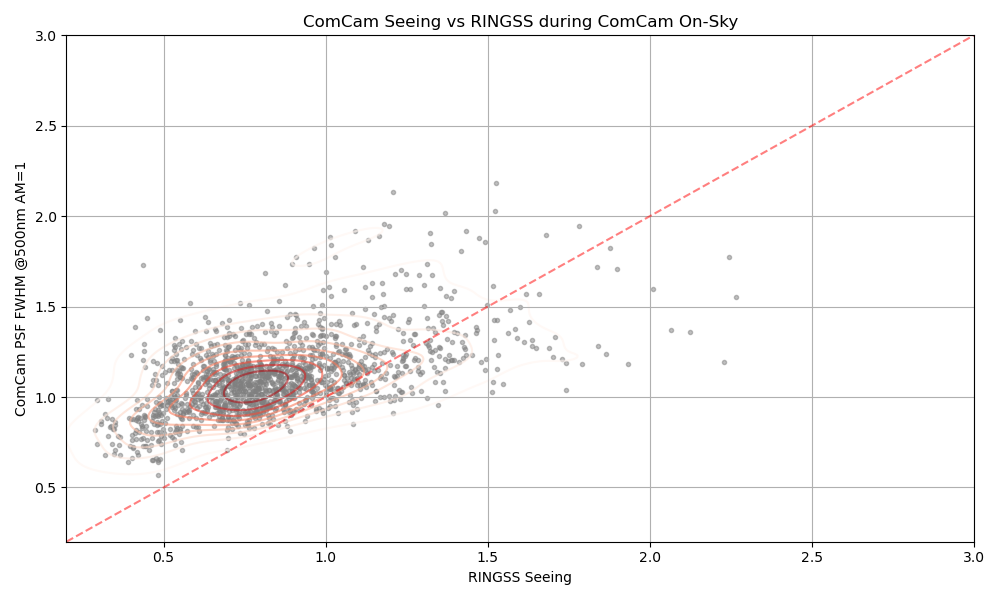

In [17]:
# Plot the time vs the specified column
plt.figure(figsize=(10, 6))
plt.plot(merged_table["see"], merged_table["fwhm_zenith_500nm"],'.', color='0.5',zorder=0, alpha=0.5)
sns.kdeplot(
    x=merged_table["see"], 
    y=merged_table["fwhm_zenith_500nm"], 
    levels=10,  # Number of contour levels
    cmap="Reds",  # Color map for contours
    alpha=0.6,
    zorder=1,
)

plt.plot(np.arange(0.2,5,0.1), np.arange(0.2,5,0.1), 'r--', alpha=0.5)
plt.ylabel('ComCam PSF FWHM @500nm AM=1')
plt.xlabel('RINGSS Seeing')
plt.xlim(0.2,3.0)
plt.ylim(0.2,3.0)
plt.title(f"ComCam Seeing vs RINGSS during ComCam On-Sky")
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

/tmp/ipykernel_3778/3196244472.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


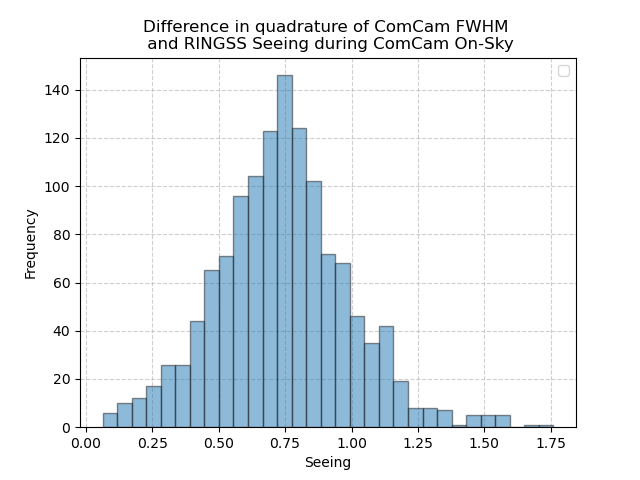

In [18]:
# Plot histogram using Freedman-Diaconis rule
plt.figure()
plt.xlabel('Seeing')
plt.ylabel("Frequency")
plt.title(f"Difference in quadrature of ComCam FWHM \n and RINGSS Seeing during ComCam On-Sky")
plt.grid(True, linestyle="--", alpha=0.6, zorder=0)
plt.hist(np.sqrt(sqr_diff[sqr_diff>0]), bins='fd', edgecolor='0.1', zorder=2,alpha=0.5)
plt.legend()
plt.show()

/tmp/ipykernel_3778/4293951270.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


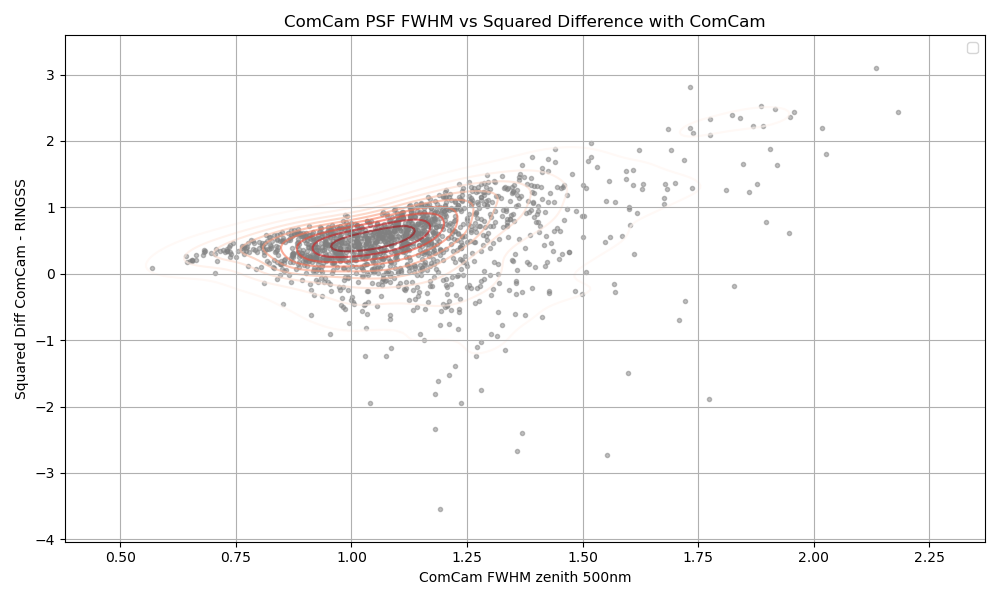

In [19]:
# Plot the time vs the specified column
plt.figure(figsize=(10, 6))
plt.plot(merged_table["fwhm_zenith_500nm"], sqr_diff,'.', color='0.5',zorder=0, alpha=0.5)
sns.kdeplot(
    x=merged_table["fwhm_zenith_500nm"], 
    y=sqr_diff, 
    levels=10,  # Number of contour levels
    cmap="Reds",  # Color map for contours
    alpha=0.6,
    zorder=1,
)

plt.ylabel('Squared Diff ComCam - RINGSS')
plt.xlabel('ComCam FWHM zenith 500nm')
plt.title(f"ComCam PSF FWHM vs Squared Difference with ComCam")
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

/tmp/ipykernel_3778/2892917107.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


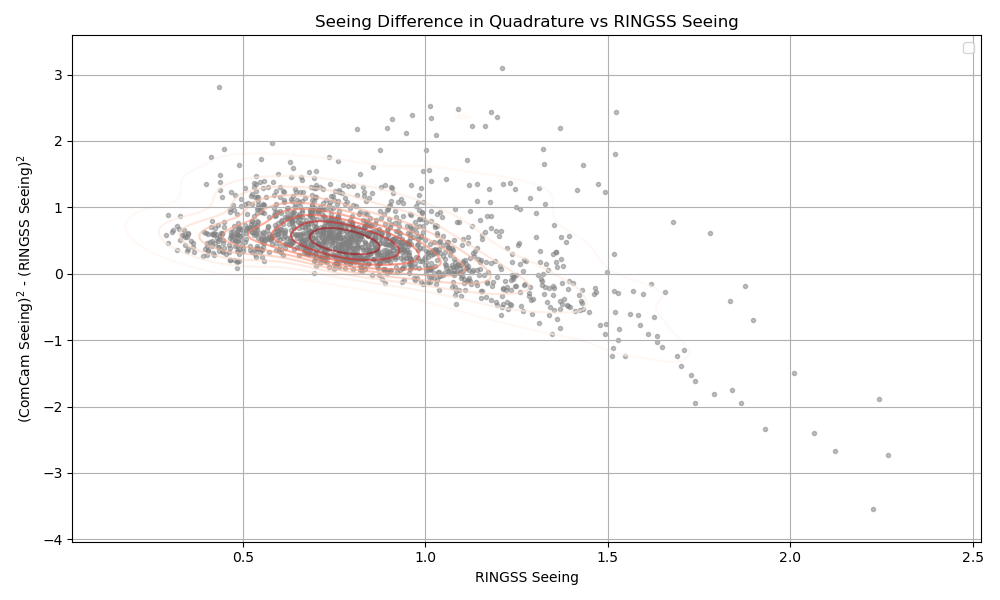

In [20]:
# Plot the time vs the specified column
plt.figure(figsize=(10, 6))
plt.plot(merged_table["see"], sqr_diff,'.', color='0.5',zorder=0, alpha=0.5)
sns.kdeplot(
    x=merged_table["see"], 
    y=sqr_diff, 
    levels=10,  # Number of contour levels
    cmap="Reds",  # Color map for contours
    alpha=0.6,
    zorder=1,
)

plt.ylabel('(ComCam Seeing)$^2$ - (RINGSS Seeing)$^2$')
plt.xlabel('RINGSS Seeing')
plt.title(f"Seeing Difference in Quadrature vs RINGSS Seeing")
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [21]:
diff = merged_table["fwhm_zenith_500nm"] - merged_table["see"]

/tmp/ipykernel_3778/3025000774.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


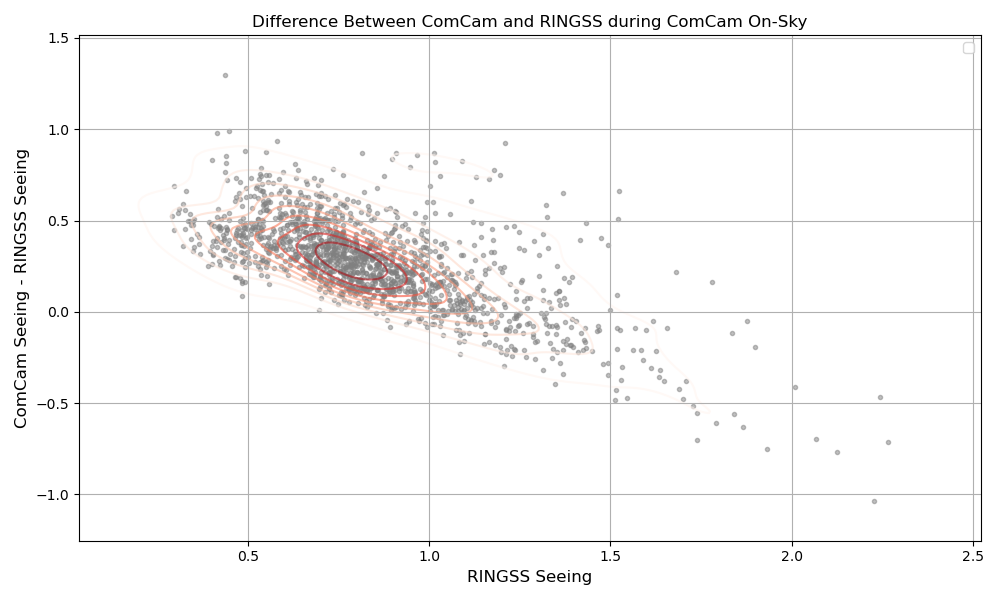

In [22]:
# Plot the time vs the specified column
plt.figure(figsize=(10, 6))
plt.plot(merged_table["see"], diff,'.', color='0.5',zorder=0, alpha=0.5)
sns.kdeplot(
    x=merged_table["see"], 
    y=diff, 
    levels=10,  # Number of contour levels
    cmap="Reds",  # Color map for contours
    alpha=0.6,
    zorder=1,
)

plt.ylabel('ComCam Seeing - RINGSS Seeing', size='large')
plt.xlabel('RINGSS Seeing', size='large')
plt.title(f"Difference Between ComCam and RINGSS during ComCam On-Sky")
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [23]:
diff_free = merged_table["fwhm_zenith_500nm"] - merged_table["fsee"]

/tmp/ipykernel_3778/416352497.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


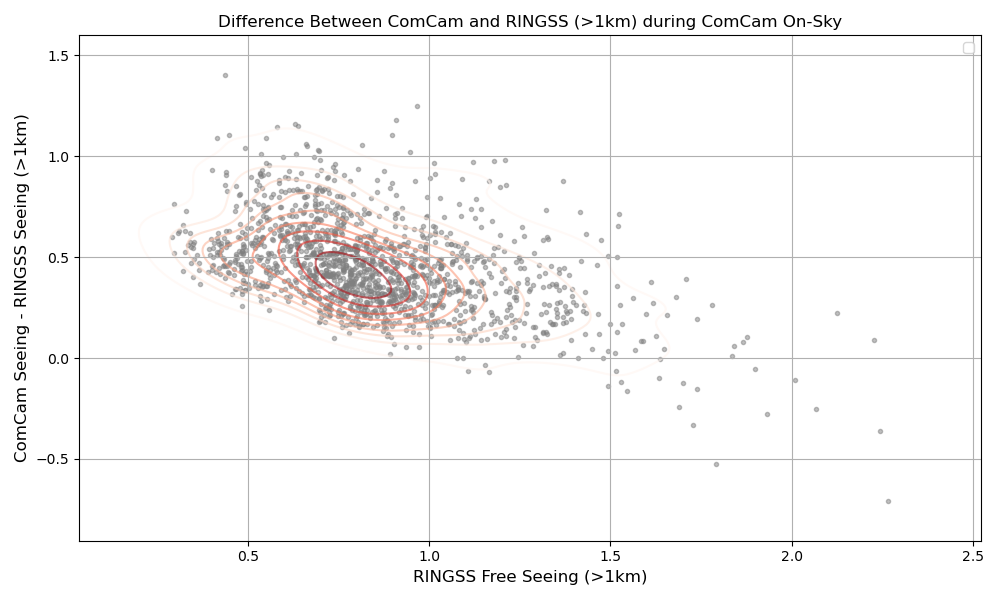

In [24]:
# Plot the time vs the specified column
plt.figure(figsize=(10, 6))
plt.plot(merged_table["see"], diff_free,'.', color='0.5',zorder=0, alpha=0.5)
sns.kdeplot(
    x=merged_table["see"], 
    y=diff_free, 
    levels=10,  # Number of contour levels
    cmap="Reds",  # Color map for contours
    alpha=0.6,
    zorder=1,
)

plt.ylabel('ComCam Seeing - RINGSS Seeing (>1km)', size='large')
plt.xlabel('RINGSS Free Seeing (>1km)', size='large')
plt.title(f"Difference Between ComCam and RINGSS (>1km) during ComCam On-Sky")
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

There seems to be an issue with our PSF measurements in the ConsDB as a function of seeing. That is, we are underestimating the PSF FWHM in the consDB at high seeing. Let's see what the DRP has. 

In [25]:
from lsst.daf.butler import Butler

collection='LSSTComCam/runs/DRP/DP1/w_2025_05/DM-48666'
butler = Butler('/sdf/group/rubin/repo/main', collections=collection)
df = butler.get("ccdVisitTable")

In [26]:
grouped_df = (
    df.groupby(["visitId"])
    .agg(lambda x: x.median() if np.issubdtype(x.dtype, np.number) else x.iloc[0])  
    .reset_index()
)
grouped_df = grouped_df.rename(columns=lambda x: f"drp_{x}")
grouped_df.rename(columns={"drp_visitId": "visit_id"})

visit_id  drp_detectorId drp_physical_filter drp_band      drp_ra  \
0     2024110800245             4.0                i_06        i   53.323752   
1     2024110800246             4.0                r_03        r   53.324199   
2     2024110800247             4.0                r_03        r   53.137948   
3     2024110800248             4.0                i_06        i   53.137695   
4     2024110800249             4.0                i_06        i   53.184703   
...             ...             ...                 ...      ...         ...   
1852  2024121100607             4.0                r_03        r  106.231576   
1853  2024121100608             4.0                r_03        r  106.241695   
1854  2024121100609             4.0                r_03        r  106.326840   
1855  2024121100610             4.0                r_03        r  106.360924   
1856  2024121100611             4.0                r_03        r  106.365616   

        drp_dec  drp_pixelScale  drp_zenithDistance  drp_expTime  \
0    -28.013506        0.200283           15.575786         30.0   
1    -28.014307        0.200331           15.826385         30.0   
2    -28.073250        0.200330           16.149603         30.0   
3    -28.072832        0.200284           16.412487         30.0   
4    -28.150420        0.200284           16.532511         30.0   
...         ...             ...                 ...          ...   
1852 -10.676081        0.200324           35.022129         30.0   
1853 -10.471924        0.200322           35.249622         30.0   
1854 -10.395099        0.200326           35.367107         30.0   
1855 -10.486699        0.200323           35.390991         30.0   
1856 -10.479400        0.200321           35.501637         30.0   

      drp_zeroPoint  ...  drp_xSize  drp_ySize   drp_llcra  drp_llcdec  \
0         31.777445  ...     4071.0     3999.0   53.172280  -28.099118   
1         31.985737  ...     4071.0     3999.0   53.172695  -28.099941   
2         31.988493  ...     4071.0     3999.0   52.986360  -28.158886   
3         31.778139  ...     4071.0     3999.0   52.986135  -28.158447   
4         31.775457  ...     4071.0     3999.0   53.033039  -28.236029   
...             ...  ...        ...        ...         ...         ...   
1852      31.967775  ...     4071.0     3999.0  106.117860  -10.788870   
1853      31.975273  ...     4071.0     3999.0  106.127583  -10.584255   
1854      31.975628  ...     4071.0     3999.0  106.176056  -10.451794   
1855      31.971622  ...     4071.0     3999.0  106.210167  -10.543597   
1856      31.971697  ...     4071.0     3999.0  106.214855  -10.536265   

       drp_ulcra  drp_ulcdec   drp_urcra  drp_urcdec   drp_lrcra  drp_lrcdec  
0      53.229508  -27.878345   53.474982  -27.927728   53.418232  -28.148603  
1      53.229929  -27.879115   53.475462  -27.928507   53.418707  -28.149435  
2      53.043630  -27.938055   53.289293  -27.987449   53.232503  -28.208382  
3      53.043403  -27.937666   53.289014  -27.987050   53.232226  -28.207934  
4      53.090342  -28.015262   53.336125  -28.064645   53.279304  -28.285514  
...          ...         ...         ...         ...         ...         ...  
1852  106.118842  -10.562355  106.345208  -10.563251  106.344395  -10.789767  
1853  106.129519  -10.357735  106.355725  -10.359554  106.353954  -10.586075  
1854  106.271871  -10.245819  106.477569  -10.338333  106.381861  -10.544370  
1855  106.305734  -10.337484  106.511627  -10.429731  106.416168  -10.635906  
1856  106.310455  -10.330179  106.516322  -10.422464  106.420831  -10.628612  

[1857 rows x 52 columns]

In [27]:
drp_table = Table.from_pandas(grouped_df)
drp_table.rename_column("drp_visitId", "visit_id")

In [28]:
merged_drp_table = join(merged_table, drp_table, keys=["visit_id"], join_type="inner")

In [29]:
merged_drp_table.columns

<TableColumns names=('time','star','zen','flux','see2','see','fsee','wind','tau0','theta0','totvar','erms','J0','J025','J05','J1','J2','J4','J8','J16','visit_id','exposure_name','controller','day_obs_1','seq_num_1','physical_filter','band','s_ra','s_dec','sky_rotation','azimuth_start','azimuth_end','azimuth','altitude_start','altitude_end','altitude','zenith_distance_start','zenith_distance_end','zenith_distance','airmass','exp_midpt','exp_midpt_mjd','obs_start','obs_start_mjd','obs_end','obs_end_mjd','exp_time','shut_time','dark_time','group_id','cur_index','max_index','img_type','emulated','science_program','observation_reason','target_name','air_temp','pressure','humidity','wind_speed','wind_dir','dimm_seeing','focus_z','simulated','s_region','n_inputs','astrom_offset_mean_min','astrom_offset_mean_max','astrom_offset_mean_median','astrom_offset_std_min','astrom_offset_std_max','astrom_offset_std_median','eff_time_min','eff_time_max','eff_time_median','eff_time_psf_sigma_scale_min','

In [30]:
# Convert PSF sigma to FWHM
sig2fwhm = 2 * np.sqrt(2 * np.log(2))
pixel_scale = 0.2  # arcsec / pixel
merged_drp_table["drp_psf_fwhm"] = merged_drp_table["drp_psfSigma"] * sig2fwhm * pixel_scale

# Add the FWHM at zenith at 500nm
merged_drp_table["drp_fwhm_zenith_500nm"] = [
    fwhm * getBandpassSeeingCorrection(filt) * getAirmassSeeingCorrection(airmass)
    for fwhm, filt, airmass in zip(merged_drp_table["drp_psf_fwhm"], merged_drp_table["physical_filter"], merged_drp_table["airmass"])
]

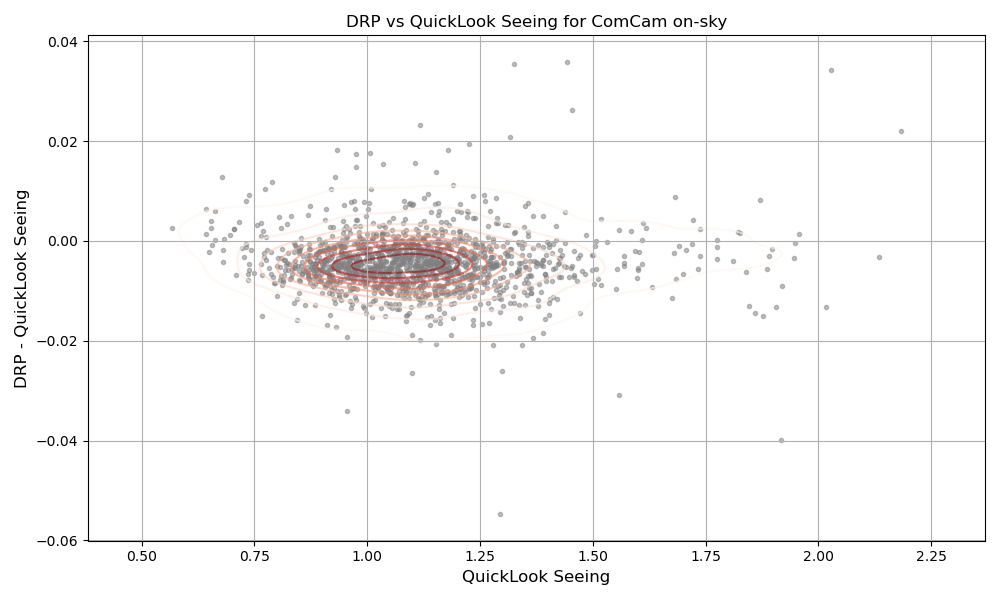

In [31]:
# Plot the time vs the specified column
plt.figure(figsize=(10, 6))
plt.plot(merged_drp_table["fwhm_zenith_500nm"], merged_drp_table["drp_fwhm_zenith_500nm"] - merged_drp_table["fwhm_zenith_500nm"],'.', color='0.5',zorder=0, alpha=0.5)
sns.kdeplot(
    x=merged_drp_table["fwhm_zenith_500nm"], 
    y=merged_drp_table["drp_fwhm_zenith_500nm"] - merged_drp_table["fwhm_zenith_500nm"], 
    levels=10,  # Number of contour levels
    cmap="Reds",  # Color map for contours
    alpha=0.6,
    zorder=1,
)

plt.xlabel('QuickLook Seeing', size='large')
plt.ylabel('DRP - QuickLook Seeing', size='large')
plt.title(f"DRP vs QuickLook Seeing for ComCam on-sky")
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [32]:
merged_drp_table.columns

<TableColumns names=('time','star','zen','flux','see2','see','fsee','wind','tau0','theta0','totvar','erms','J0','J025','J05','J1','J2','J4','J8','J16','visit_id','exposure_name','controller','day_obs_1','seq_num_1','physical_filter','band','s_ra','s_dec','sky_rotation','azimuth_start','azimuth_end','azimuth','altitude_start','altitude_end','altitude','zenith_distance_start','zenith_distance_end','zenith_distance','airmass','exp_midpt','exp_midpt_mjd','obs_start','obs_start_mjd','obs_end','obs_end_mjd','exp_time','shut_time','dark_time','group_id','cur_index','max_index','img_type','emulated','science_program','observation_reason','target_name','air_temp','pressure','humidity','wind_speed','wind_dir','dimm_seeing','focus_z','simulated','s_region','n_inputs','astrom_offset_mean_min','astrom_offset_mean_max','astrom_offset_mean_median','astrom_offset_std_min','astrom_offset_std_max','astrom_offset_std_median','eff_time_min','eff_time_max','eff_time_median','eff_time_psf_sigma_scale_min','

In [33]:
merged_drp_table['drp_seeing'] - merged_drp_table['drp_fwhm_zenith_500nm']

<Column name='drp_seeing' dtype='float64' length=1441>
 -0.02008435314345025
    -0.07259796797119
  0.03945230116049725
 0.006740646544030726
-0.017348403155449388
 -0.02198664347245094
-0.057896929031930444
  -0.0841135256726877
 -0.08867845658939699
 -0.06243268821467385
 -0.02833987759226053
  -0.0647215859756578
                  ...
  0.08797498721737806
  0.09531601848582483
  0.10024285716931869
   0.1593639808613645
   0.1248504048423883
   0.0633369195085699
  0.06229526436527777
 0.055032096943973596
   0.0636003766565919
 0.059503702488994836
 0.059503702488994836

There's a value in the visit summary table called seeing? I'm not sure where this is coming from, but the distribution looks quite different than what RINGSS measured.

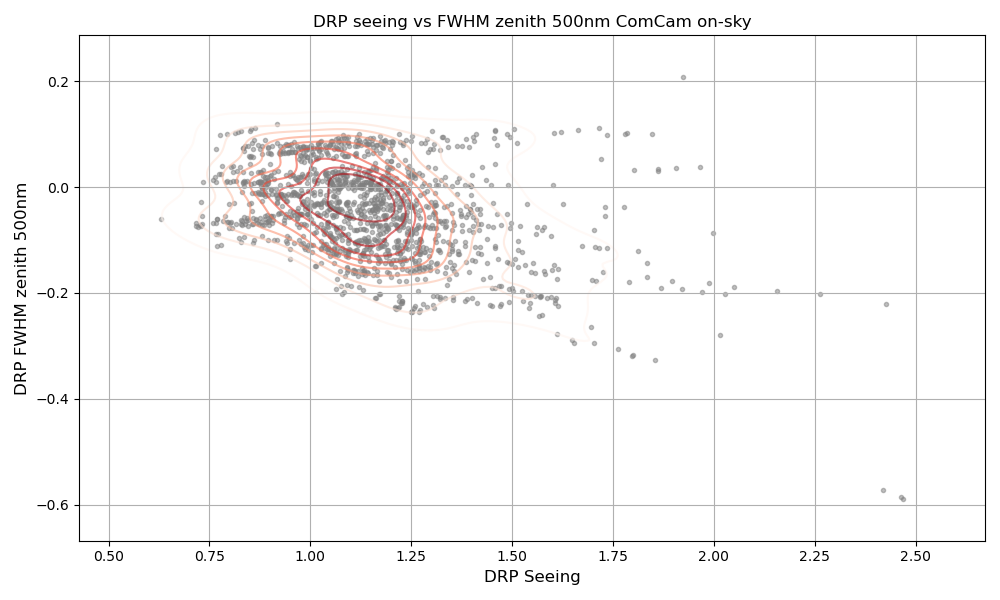

In [34]:
# Plot the time vs the specified column
plt.figure(figsize=(10, 6))
plt.plot(merged_drp_table["drp_seeing"], merged_drp_table["drp_fwhm_zenith_500nm"] - merged_drp_table['drp_seeing'],'.', color='0.5',zorder=0, alpha=0.5)
sns.kdeplot(
    x=merged_drp_table["drp_seeing"], 
    y=merged_drp_table["drp_fwhm_zenith_500nm"] - merged_drp_table['drp_seeing'], 
    levels=10,  # Number of contour levels
    cmap="Reds",  # Color map for contours
    alpha=0.6,
    zorder=1,
)

plt.xlabel('DRP Seeing', size='large')
plt.ylabel('DRP FWHM zenith 500nm', size='large')
plt.title(f"DRP seeing vs FWHM zenith 500nm ComCam on-sky")
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

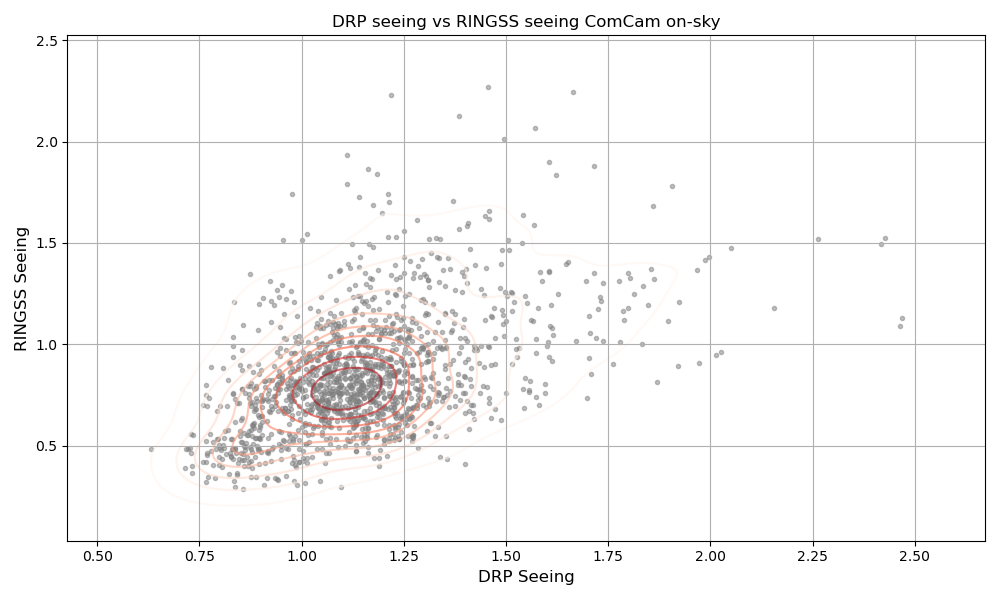

In [35]:
# Plot the time vs the specified column
plt.figure(figsize=(10, 6))
plt.plot(merged_drp_table["drp_seeing"], merged_drp_table["see"],'.', color='0.5',zorder=0, alpha=0.5)
sns.kdeplot(
    x=merged_drp_table["drp_seeing"], 
    y=merged_drp_table["see"], 
    levels=10,  # Number of contour levels
    cmap="Reds",  # Color map for contours
    alpha=0.6,
    zorder=1,
)

plt.xlabel('DRP Seeing', size='large')
plt.ylabel('RINGSS Seeing', size='large')
plt.title(f"DRP seeing vs RINGSS seeing ComCam on-sky")
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

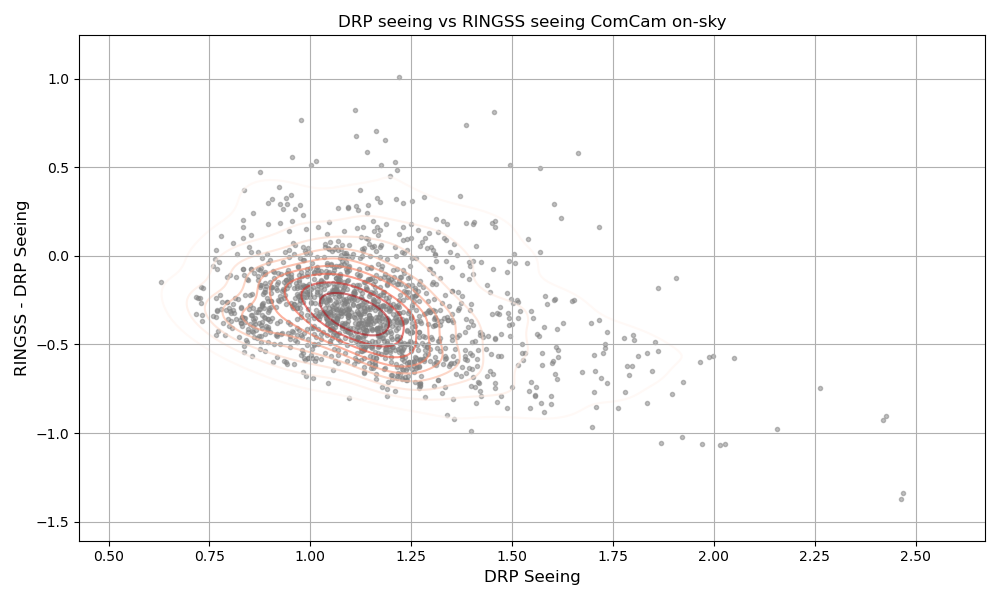

In [36]:
# Plot the time vs the specified column
plt.figure(figsize=(10, 6))
plt.plot(merged_drp_table["drp_seeing"], merged_drp_table["see"]-merged_drp_table["drp_seeing"],'.', color='0.5',zorder=0, alpha=0.5)
sns.kdeplot(
    x=merged_drp_table["drp_seeing"], 
    y=merged_drp_table["see"]-merged_drp_table["drp_seeing"], 
    levels=10,  # Number of contour levels
    cmap="Reds",  # Color map for contours
    alpha=0.6,
    zorder=1,
)

plt.xlabel('DRP Seeing', size='large')
plt.ylabel('RINGSS - DRP Seeing', size='large')
plt.title(f"DRP seeing vs RINGSS seeing ComCam on-sky")
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

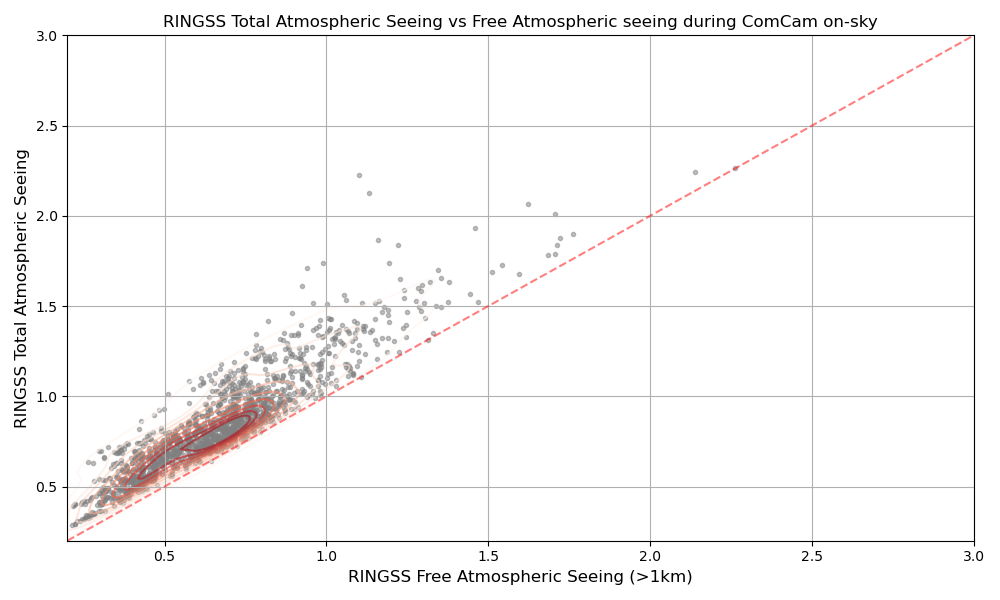

In [37]:
# Plot the time vs the specified column
plt.figure(figsize=(10, 6))
plt.plot(merged_drp_table["fsee"], merged_drp_table["see"],'.', color='0.5',zorder=0, alpha=0.5)
sns.kdeplot(
    x=merged_drp_table["fsee"], 
    y=merged_drp_table["see"], 
    levels=10,  # Number of contour levels
    cmap="Reds",  # Color map for contours
    alpha=0.6,
    zorder=1,
)
plt.plot(np.arange(0.2,5,0.1), np.arange(0.2,5,0.1), 'r--', alpha=0.5)
plt.xlim(0.2,3.)
plt.ylim(0.2,3.)
plt.ylabel('RINGSS Total Atmospheric Seeing', size='large')
plt.xlabel('RINGSS Free Atmospheric Seeing (>1km)', size='large')
plt.title(f"RINGSS Total Atmospheric Seeing vs Free Atmospheric seeing during ComCam on-sky")
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

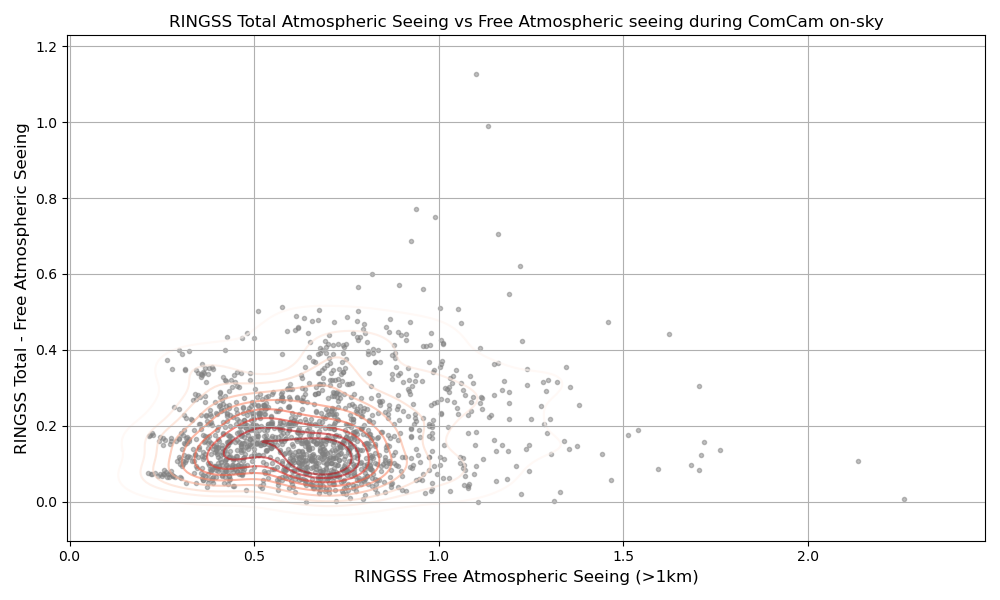

In [38]:
# Plot the time vs the specified column
plt.figure(figsize=(10, 6))
plt.plot(merged_drp_table["fsee"], merged_drp_table["see"]-merged_drp_table["fsee"],'.', color='0.5',zorder=0, alpha=0.5)
sns.kdeplot(
    x=merged_drp_table["fsee"], 
    y=merged_drp_table["see"]-merged_drp_table["fsee"], 
    levels=10,  # Number of contour levels
    cmap="Reds",  # Color map for contours
    alpha=0.6,
    zorder=1,
)

plt.ylabel('RINGSS Total - Free Atmospheric Seeing', size='large')
plt.xlabel('RINGSS Free Atmospheric Seeing (>1km)', size='large')
plt.title(f"RINGSS Total Atmospheric Seeing vs Free Atmospheric seeing during ComCam on-sky")
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

Let's see if we can grab a PSF model and plot some residuals for visits in the "bad" region. 

In [39]:
merged_drp_table.columns

<TableColumns names=('time','star','zen','flux','see2','see','fsee','wind','tau0','theta0','totvar','erms','J0','J025','J05','J1','J2','J4','J8','J16','visit_id','exposure_name','controller','day_obs_1','seq_num_1','physical_filter','band','s_ra','s_dec','sky_rotation','azimuth_start','azimuth_end','azimuth','altitude_start','altitude_end','altitude','zenith_distance_start','zenith_distance_end','zenith_distance','airmass','exp_midpt','exp_midpt_mjd','obs_start','obs_start_mjd','obs_end','obs_end_mjd','exp_time','shut_time','dark_time','group_id','cur_index','max_index','img_type','emulated','science_program','observation_reason','target_name','air_temp','pressure','humidity','wind_speed','wind_dir','dimm_seeing','focus_z','simulated','s_region','n_inputs','astrom_offset_mean_min','astrom_offset_mean_max','astrom_offset_mean_median','astrom_offset_std_min','astrom_offset_std_max','astrom_offset_std_median','eff_time_min','eff_time_max','eff_time_median','eff_time_psf_sigma_scale_min','

In [40]:
bad_visitIds = merged_drp_table[np.where((merged_drp_table['see']>1.5)&(merged_drp_table['drp_fwhm_zenith_500nm']<1.25))]['visit_id']

In [41]:
len(bad_visitIds)

13

In [42]:
good_visitIds = merged_drp_table[np.where((merged_drp_table['see']<0.8)&(merged_drp_table['drp_fwhm_zenith_500nm']>0.8))]['visit_id']

In [43]:
len(good_visitIds)

656

From a notebook that Josh M. posted called PSF RA Plot

In [44]:
from lsst.summit.extras.plotting.psfPlotting import makeAzElPlot, makeTableFromSourceCatalogs
from lsst.obs.lsst import LsstComCam

In [45]:
from lsst.summit.extras.plotting.psfPlotting import makeAzElPlot, makeTableFromSourceCatalogs
from lsst.obs.lsst import LsstComCam

In [49]:
butler_nightly = Butler(
    "embargo", 
    # collections=["LSSTComCam/quickLook"], 
    collections=["LSSTComCam/nightlyValidation"], 
    instrument="LSSTComCam"
)

camera = LsstComCam().getCamera()

In [78]:
visit_id = bad_visitIds[1]
#visit_id = good_visitIds[0]

In [80]:
visit_id

2024112300247

In [81]:
merged_drp_table[np.where(merged_drp_table['visit_id']==visit_id)]['drp_psf_fwhm']

<Column name='drp_psf_fwhm' dtype='float64' length=1>
1.228557677941121

In [60]:
icSrcs = {}
for i in range(9):
    icSrcs[i] = butler_nightly.get("icSrc", dataId={"visit":visit_id, "detector":i})
visitInfo = butler_nightly.get("postISRCCD.visitInfo", dataId={"exposure":visit_id, "detector":4})
table = makeTableFromSourceCatalogs(icSrcs, visitInfo)

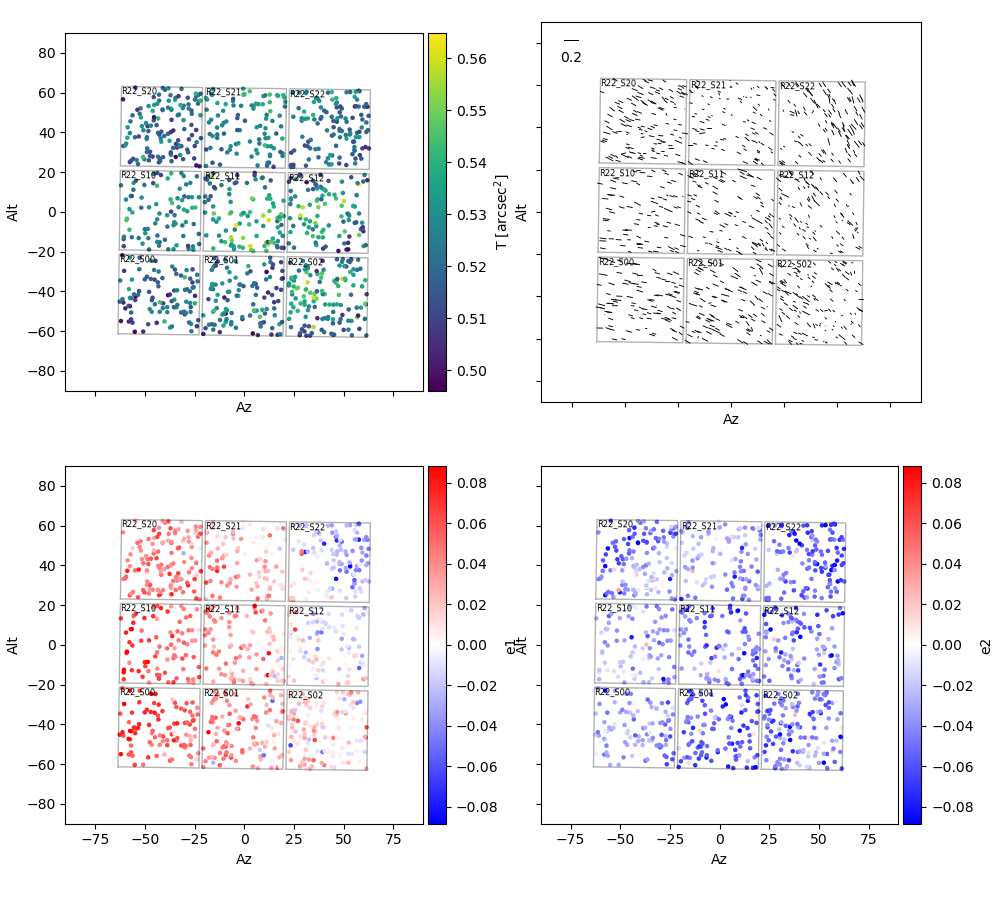

In [61]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True)
makeAzElPlot(fig, axes, table, camera)
plt.show()